In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import sys
sys.path.append('/home/chendian/PURE')

import time
import logging
from glob import glob
from pure_api import PureApi
from shared.data_structures import Dataset

use_cuda: True


In [67]:
task_name = 'resume'
from modules.sample_augmentor import SampleAugmentor
augmentor = SampleAugmentor(
    sample_file_dir=f'/home/chendian/PURE/data/{task_name}/', 
    task_name=task_name,
    elib_path=None)

The entities in current dataset have 1682 unique chars.


In [68]:
augmentor.ner_id2label

{1: '公司', 2: '人名', 3: '地址', 4: '学历', 5: '专业', 6: '国籍', 7: '民族', 8: '职称'}

In [69]:
from modules.span_filter import SpanFilter
from run_entity import get_labelmap, task_ner_labels
ner_label2id, ner_id2label = get_labelmap(task_ner_labels[task_name])
num_ner_labels = len(ner_label2id.keys()) + 1

import numpy as np
span_filter = SpanFilter(
    ner_label2id=ner_label2id,
    max_span_length=25,
    drop_with_punc=True,
    filter_method=np.max,
    filter_threshold=0.0,
    boundary_only_mode='targeted',
    method='',
)

In [56]:
import json
# inv_dump_path = f'/home/chendian/PURE/data/msra_origin/inv_test.json'
inv_dump_path = f'/home/chendian/PURE/data/msra_inv/dev_org.json'
origin_msra_inv = json.load(open(inv_dump_path, 'r'))

In [70]:
import json
task_name = 'resume'
inv_dump_path = f'/home/chendian/PURE/data/{task_name}/inv_test_500.json'
resume_inv = json.load(open(inv_dump_path, 'r'))

In [56]:
import json
task_name = 'onto4'
inv_dump_path = f'/home/chendian/PURE/data/{task_name}/inv_test_500.json'
onto4_inv = json.load(open(inv_dump_path, 'r'))

In [71]:
from entity.utils import convert_dataset_to_samples
data = Dataset(inv_dump_path)
_samples, _ner = convert_dataset_to_samples(
    data, 25, context_window=0,
    span_filter=span_filter, 
    is_training=False)

11/15/2021 17:01:39 - INFO - root - # Overlap: 0
11/15/2021 17:01:39 - INFO - root - Extracted 279 samples from 1 documents, with 279 NER labels, 22.986 avg input length, 167 max length
11/15/2021 17:01:39 - INFO - root - Max Length: 167, max NER: 1
11/15/2021 17:01:39 - INFO - root - Span Candidates' Count: 279, Cover: 279


In [ ]:
inv_dump_heatmap_path = f'/home/chendian/PURE/data/{task_name}/inv_test_heatmap.json'

In [ ]:
# samples = augmentor.get_samples_from_jsonl(inv_dump_path)

In [5]:
ds = Dataset(inv_dump_path)

In [46]:
from tqdm import tqdm
from entity.utils import (
    batchify, convert_dataset_to_samples,
    logger, output_ner_predictions, NpEncoder)

def get_jsonl_from_samples(self, samples, output_file=None, doc_key='dummy'):
    js = []
    doc = {'sentences': [], 'ner': [], 'relations': [], 'doc_key': doc_key}
    offset = 0
    for sample in tqdm(samples):
        doc['sentences'].append(sample['tokens'])
        ner_case = []
        for _sp, _l in zip(sample['spans'], sample['spans_label']):
            ner_case.append([_sp[0] + offset, _sp[1] + offset, self.ner_id2label[_l]])
        doc['ner'].append(ner_case)
        offset += len(sample['tokens'])
    doc['relations'] = [[] for _ in doc['ner']]
    js.append(doc)
    if output_file:
        with open(output_file, 'w') as f:
            f.write('\n'.join(json.dumps(doc, cls=NpEncoder) for doc in js))
    return js

In [75]:
ent_case = []
sample_case = []
for sample in _samples:
    if sample['spans_label'][0] != 2:
        continue
    sample_case.append(sample)
    tokens = sample['tokens']
    for lef, rig, _ in sample['spans']:
        ent = tokens[lef:rig+1]
        if ent not in ent_case:
            ent_case.append(ent)
inv_samples = augmentor.generate_inv_samples(samples=sample_case, entities=ent_case)

len(ent_case), len(sample_case), len(inv_samples)

(90, 92, 8280)

In [74]:
js_org = get_jsonl_from_samples(
    augmentor, samples=inv_samples,
    output_file=f'/home/chendian/PURE/data/{task_name}/inv_test_org.json', 
    doc_key='onto4-inv-org')
print(len(js_org), len(js_org[0]['sentences']))

100%|██████████| 27302/27302 [00:00<00:00, 366640.69it/s]


1 27302


In [76]:
js_per = get_jsonl_from_samples(
    augmentor, samples=inv_samples,
    output_file=f'/home/chendian/PURE/data/{task_name}/inv_test_per.json', 
    doc_key='onto4-inv-per')
print(len(js_per), len(js_per[0]['sentences']))

100%|██████████| 8280/8280 [00:00<00:00, 355344.02it/s]

1 8280


In [77]:
js = js_per + js_org 
with open(f'/home/chendian/PURE/data/{task_name}/inv_test_all.json', 'w') as f:
    f.write('\n'.join(json.dumps(doc, cls=NpEncoder) for doc in js))
len(js), task_name

(2, 'resume')

In [73]:
inv_samples[12]

{'doc_key': 'resume-doc-selected-500',
 'sentence_ix': 0,
 'tokens': ['T', 'C', 'L', '电', '脑', '公', '司', '独', '立', '董', '事', '；'],
 'sent_length': 12,
 'sent_start': 0,
 'sent_end': 12,
 'sent_start_in_doc': 0,
 'spans': [(0, 6, 7)],
 'spans_label': [1],
 'positive_labels_count': 1,
 'positive_labels_cover': 1}

(73.0, 61.0)

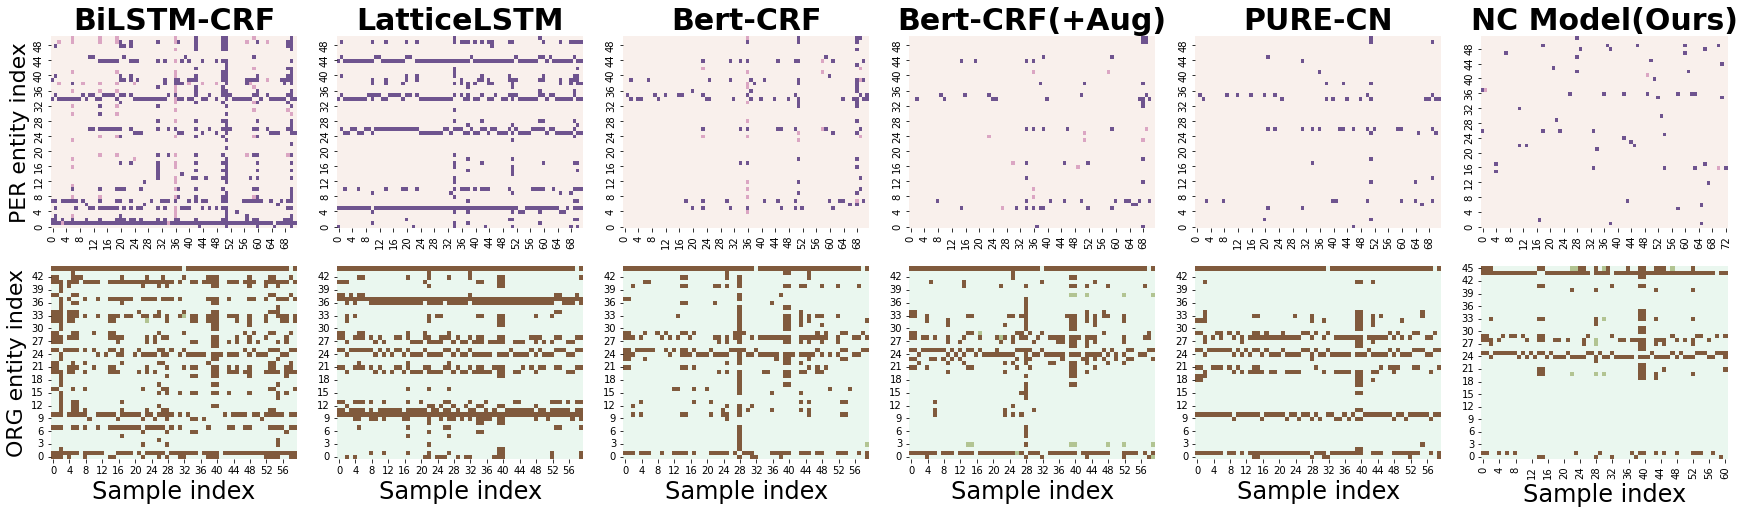

In [90]:
import pickle
import warnings
import seaborn as sns
from pylab import *  # 支持中文
import matplotlib.pyplot as plt

def draw_multi_heatmap():
    # plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

    plt.figure(figsize=(24, 7))
    plt.figure(1)

    model_case = ['LSTM-CRF', 'LatticeLSTM', 'Bert-CRF', 'Bert-CRF-with-Aug', 'PURE', 'NCModel']
    show_name_case = ['BiLSTM-CRF', 'LatticeLSTM', 'Bert-CRF', 'Bert-CRF(+Aug)', 'PURE-CN', 'NC Model(Ours)']
    tag_type_case = ['PER', 'ORG']
    irol = len(tag_type_case)
    icol = len(model_case)
    hm_pos_case = [(irol, icol, x) for x in range(1, irol * icol + 1)]
    for idx, hm_pos in enumerate(hm_pos_case):
        ax = plt.subplot(*hm_pos)
        cmap = sns.cubehelix_palette(start=(hm_pos[-1] - 1) // icol, gamma=0.5, light=.9, as_cmap=True)
        dat = pickle.load(
            open('/home/chendian/doc_ner/data/heatmap/{}_{}.pkl'.format(
                tag_type_case[idx // icol], model_case[idx % icol]), 'rb'))
        # dat = (np.random.random([20, 50]) > 0.5).astype(int)
        sns.heatmap(dat,
                    cmap=cmap, linewidths=0, ax=ax, cbar=False).invert_yaxis()
        if tag_type_case[idx // icol] == 'PER':
            ax.set_title('{}'.format(
                show_name_case[idx % icol]
            ), fontdict={'weight': 'bold', 'size': 30})
            if show_name_case[idx % icol] == "BiLSTM-CRF":
                ax.set_ylabel('PER entity index', fontdict={'weight': 'normal', 'size': 22})
        else:
            ax.set_xlabel('Sample index', fontdict={'weight': 'normal', 'size': 24})
            if show_name_case[idx % icol] == "BiLSTM-CRF":
                ax.set_ylabel('ORG entity index', fontdict={'weight': 'normal', 'size': 22})

    plt.tight_layout(pad=0.2, w_pad=2.0, h_pad=1.5)
    plt.savefig('./sns_heatmap_normal_211115.jpg', bbox_inches='tight')
    plt.show()
    
    
draw_multi_heatmap()

In [85]:
!ls -lht /data/chendian/nc_output_dir/msra_origin_spanc_3e2_wnca_biaffine_aug_fix/

total 515M
-rw-rw-r-- 1 chendian chendian  68M Nov 16 13:26 ent_pred_test.json
-rw-rw-r-- 1 chendian chendian  17K Nov 16 13:26 train.log
-rw-rw-r-- 1 chendian chendian 2.0M Nov 16 12:08 inv_test_org_ent_pred_test.json
-rw-rw-r-- 1 chendian chendian 3.3K Nov 16 12:08 eval.log
-rw-rw-r-- 1 chendian chendian 2.5M Nov 16 12:05 inv_test_per_ent_pred_test.json
-rw-rw-r-- 1 chendian chendian 4.4M Nov 16 11:59 inv_test_all_ent_pred_test.json
-rw-rw-r-- 1 chendian chendian 107K Nov 16 02:53 vocab.txt
-rw-rw-r-- 1 chendian chendian  112 Nov 16 02:53 special_tokens_map.json
-rw-rw-r-- 1 chendian chendian   62 Nov 16 02:53 tokenizer_config.json
-rw-rw-r-- 1 chendian chendian 439M Nov 16 02:53 pytorch_model.bin
-rw-rw-r-- 1 chendian chendian  657 Nov 16 02:53 config.json


In [88]:
import numpy as np

mat = np.ones([200, 200])
max_row, max_col = 0, 0
# inv_test_on_msra = json.load(open('/home/chendian/PURE/inv_test_on_msra_per.json', 'r'))
# inv_test_on_msra = json.load(open('/home/chendian/PURE/inv_test_on_msra_org.json', 'r'))
inv_test_on_msra = json.load(open('/data/chendian/nc_output_dir/msra_origin_spanc_3e2_wnca_biaffine_aug_fix/inv_test_org_ent_pred_test.json', 'r'))

# MSRA
# 3796 = 52 x 73, 2806 = 46 x 61
# n_samples = 73
n_samples = 46
for idx, labels in enumerate(inv_test_on_msra['ner']):
    preds = inv_test_on_msra['predicted_ner'][idx]
    # row, col = idx // n_samples, idx % n_samples
    row, col = idx % n_samples, idx // n_samples
    max_row = max(row, max_row)
    max_col = max(col, max_col)
    for _l, _p in zip(labels, preds):
        if _l == _p:
            mat[row, col] = 0
        else:
            mat[row, col] = 0.5

mat = mat[:max_row + 1, :max_col + 1]
print((mat > 0).sum() / (mat.shape[0] * mat.shape[1]))

import pickle
pickle.dump(mat, open('/home/chendian/doc_ner/data/heatmap/ORG_NCModel.pkl', 'wb'))
# pickle.dump(mat, open('/home/chendian/doc_ner/data/heatmap/PER_NCModel.pkl', 'wb'))
# return mat

0.09265858873841767


In [103]:
len(inv_test_on_msra['ner']) / 61, len(inv_test_on_msra['predicted_ner']) / 61

(46.0, 46.0)

In [82]:
mat

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])